In [2]:
#install dependencies
!pip3 install numpy scipy matplotlib schemdraw

import numpy as np
import matplotlib.pyplot as plt


!python3 -m pip install --upgrade pip
!python3 -m pip install jax jaxlib

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import random, lax, vmap
from jax import jit

## Creating a random number distribution
Demonstrating how to create an array of random numbers using NumPy and visualize the distribution of these numbers with a histogram.

Text(0, 0.5, 'Frequency')

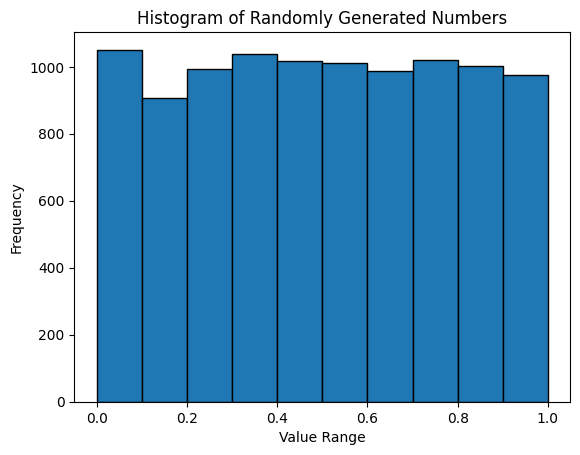

In [3]:
#creating an array
random_array = np.random.uniform(low=0.0, high=1.0, size=10000) 

plt.hist(random_array, bins=10, edgecolor='black')
plt.title('Histogram of Randomly Generated Numbers')
plt.xlabel('Value Range')
plt.ylabel('Frequency')

## Creating a Gaussian Distribution Using Monte Carlo Markov Chains

In this section I am creating a Gaussian distribution bell curve using random numbers and the Metropolis-Hastings algorithm, a type of Monte Carlo Markov Chain (MCMC) method. The process includes generating samples, calculating block variances, and analyzing the autocorrelation function across multiple chains.

### Monte Carlo Markov Chains (MCMC)
Monte Carlo Markov Chains are a class of algorithms that rely on repeated random sampling to obtain numerical results. The Metropolis-Hastings algorithm is used to generate samples from a specified probability distribution, in this case, a Gaussian distribution.

### Key Components:
1. **Generating Samples**:
    - Using the Metropolis-Hastings algorithm, we generate samples that follow a Gaussian distribution.
    - Multiple chains are used to ensure thorough exploration of the sample space.

2. **Block Analysis**:
    - The generated samples are divided into blocks, and the mean and variance of each block are calculated.
    - This helps in understanding the stability and variance of the generated samples.

3. **Autocorrelation Function**:
    - Measures the relationship between elements of the sequence of samples at different lags.
    - Important for understanding the dependencies and effective sample size of the generated samples.

4. **Proposal Function**:
    - Proposes new sample values based on the current sample and a small random perturbation.
    - Ensures that the new samples stay within the desired range and follow the target distribution.

5. **Probability Function**:
    - Calculates the probability density of a given state, assuming a Gaussian distribution.
    - Used to compute the acceptance ratio for the Metropolis-Hastings algorithm.

6. **Metropolis-Hastings Algorithm**:
    - A single iteration involves proposing a new sample, calculating the acceptance ratio, and deciding whether to accept the new sample based on this ratio.
    - Adjusts parameters dynamically to maintain an appropriate acceptance rate.


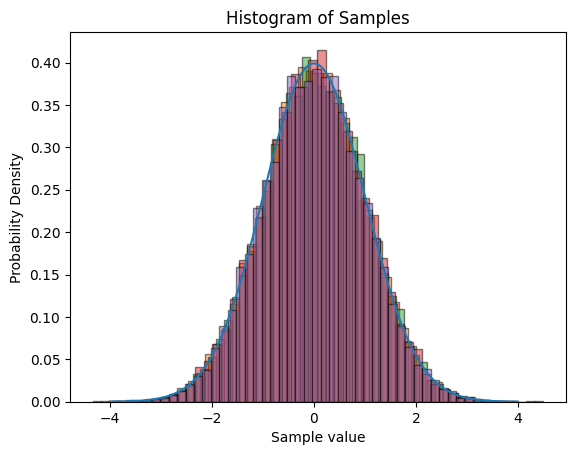

Empirical mean μ:               [-0.00415816  0.00597173  0.00228503 -0.01109298]
Variance σ2:                    [1.0054501 1.012789  1.0082158 1.0023599]
Standard deviation σ:           [1.0027213 1.0063742 1.0040995 1.0011792]
Standard error of the mean σx̅:  [0.00747405 0.00750128 0.00748432 0.00746256]
Block variances:                [0.03522382 0.03802901 0.03474527 0.0347094 ]


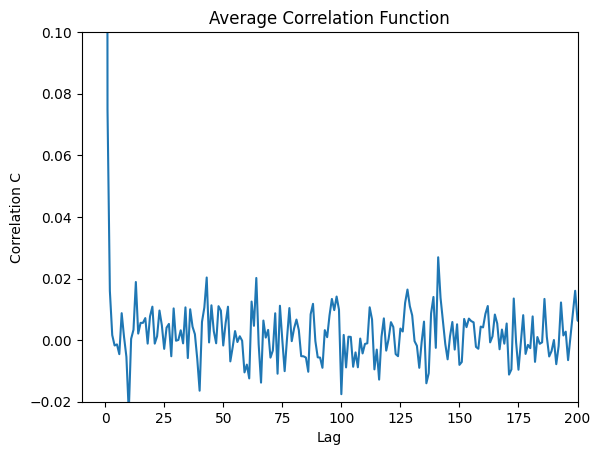

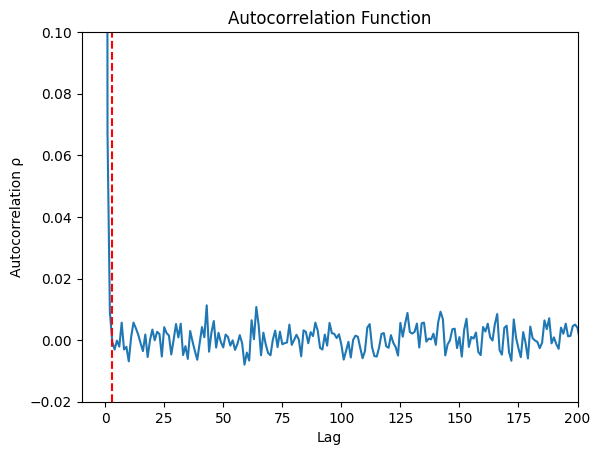

Autocorrelation time τ:  2.6528947
Effective Sample Size (ESS): 6784.664


In [5]:
#calculating block variance
def block_analysis(samples, bin_length):
    num_samples, num_chains = samples.shape
    N_bin = num_samples // bin_length  #number of bins
    block_means = jnp.zeros((N_bin, num_chains))

    @jit
    def compute_block_mean(i, block_means):
        start_idx = i * bin_length #starting index of the block
        block = lax.dynamic_slice(samples, (start_idx, 0), (bin_length, num_chains)) #extracting block of samples array starting at start_idx and spanning bin_length rows and num_chains columns
        block_mean = jnp.mean(block, axis=0)
        block_means = block_means.at[i].set(block_mean)
        return block_means

    block_means = lax.fori_loop(0, N_bin, compute_block_mean, block_means)
    overall_mean = jnp.mean(block_means, axis=0)
    block_variances = jnp.sum((block_means - overall_mean) ** 2, axis=0) / N_bin
    return block_means, block_variances

@jit #autocorrelation function using the Fast Fourier Transform
def corr_fn_fft(x):
    n = len(x)
    A = jnp.fft.rfft(x - x.mean(axis=0), n=2*n)
    B = A * A.conj() / len(x)
    return jnp.fft.irfft(B)[:n] / ((x**2).mean(axis=0) - x.mean(axis=0)**2)

@jit #calculating C function
def C_fn(chain):
    n = len(chain)
    mean = jnp.mean(chain)
    chain_centered = chain - mean
    
    C = jnp.correlate(chain_centered, chain_centered, mode='full')
    C = C[n-1:]  #only non negative lags
    normalization = jnp.arange(n, 0, -1)
    C = C / normalization
    return C

@jit #calculating the proposed new value
def proposal_function(X_current, epsilon, key):
    return X_current + epsilon * (random.uniform(key, shape=X_current.shape, minval=-0.5, maxval=0.5))

@jit #calculating the Gaussian probability density of a given state X
def probability_function(X, sigma, mean):
    return (1 / (sigma * jnp.sqrt(2 * jnp.pi))) * jnp.exp(-(X - mean) ** 2 / (2 * sigma ** 2))

@jit #single metropolis-hasting iteration
def step(X_current, epsilon, sigma, mean, key):
    key, subkey = random.split(key)
    X_prime = proposal_function(X_current, epsilon, subkey)
    acceptance_ratio = jnp.minimum(1.0, probability_function(X_prime, sigma, mean) / probability_function(X_current, sigma, mean))
    accept_condition = (random.uniform(key, shape=X_current.shape) < acceptance_ratio)
    X_next = lax.select(accept_condition, X_prime, X_current)
    return X_next, accept_condition, key

#the whole MCMC process
def mcmc_scan(iterations, thermalization, step_recording, adjustment_interval, X_initial, epsilon, sigma, mean, key, samples):
    
    #single iteration
    @jit
    def update_function(state, _):
        X_current, accepted, epsilon, key, i, samples, sample_count = state
        X_current, accept, key = step(X_current, epsilon, sigma, mean, key)
        accepted += jnp.sum(accept) #summing all accepted values across all chains

        #setting samples according to thermalization and step recording
        add_sample_condition = (i > thermalization) & ((i - thermalization) % step_recording == 0)
        samples = lax.select(add_sample_condition, samples.at[sample_count].set(X_current), samples)
        sample_count += add_sample_condition

        #adjusting epsilon according to adjustment_interval
        epsilon_adjustment_condition = (i % adjustment_interval == 0) & (i != 0)
        acceptance_rate = accepted / (i * X_current.shape[0])
        epsilon_adjusted = lax.select(acceptance_rate < 0.3, epsilon * 0.9, lax.select(acceptance_rate > 0.7, epsilon * 1.1, epsilon))
        epsilon = lax.select(epsilon_adjustment_condition, epsilon_adjusted, epsilon)

        return (X_current, accepted, epsilon, key, i + 1, samples, sample_count), None

    initial_state = (X_initial, 0, epsilon, key, 0, samples, 0)
    final_state, _ = lax.scan(update_function, initial_state, None, length=iterations)
    final_samples = final_state[5][:final_state[6]] #optional if the sample_array_size is accurate: [5] is samples, [6] is sample_count

    return final_samples, final_state

def main():
    iterations = 100000
    num_chains = 4
    sigma = 1
    mean = 0
    epsilon = 0.5

    step_recording = 5
    thermalization = int(0.1 * iterations)
    adjustment_interval = 50

    key = random.PRNGKey(0)

    X_initial = random.uniform(key, shape=(num_chains,), minval=-0.5, maxval=0.5)

    sample_array_size = (iterations - thermalization) // step_recording + 1
    samples = jnp.zeros((sample_array_size, num_chains))
    samples, final_state = mcmc_scan(iterations, thermalization, step_recording, adjustment_interval, X_initial, epsilon, sigma, mean, key, samples)

    #------------------------ PLOT THE DISTRIBUTION
    x = jnp.linspace(-4, 4, 1000)
    plt.plot(x, probability_function(x, sigma, mean).block_until_ready())
    for chain_samples in samples.T:
        plt.hist(chain_samples, bins=50, edgecolor='black', density=True, alpha=0.5)
    plt.title('Histogram of Samples')
    plt.xlabel('Sample value')
    plt.ylabel('Probability Density')
    plt.show()

    #------------------------ STATS
    N = samples.shape[0]  #number of samples
    empirical_mean = jnp.mean(samples, axis=0)
    variance = jnp.var(samples, axis=0)
    std_deviation = jnp.sqrt(variance)
    std_error_of_mean = std_deviation / jnp.sqrt(N)

    print("Empirical mean μ:              ", empirical_mean)
    print("Variance σ2:                   ", variance)
    print("Standard deviation σ:          ", std_deviation)
    print("Standard error of the mean σx̅: ", std_error_of_mean)

    #------------------------ BLOCK ANALYSIS
    block_size = 32  #can adjust as needed
    block_means, block_variances = block_analysis(samples, block_size)

    print("Block variances:               ", block_variances)
    
    #------------------------ AVERAGE CORRELATION FUNCTION
    max_var_index = jnp.argmax(block_variances) #selecting the chain with the biggest block variance
    selected_chain = samples[:, max_var_index]
    C_function = C_fn(selected_chain)

    plt.figure()
    plt.plot(C_function)
    plt.xlim(-10, 200)  
    plt.ylim(-0.02, 0.1)  
    plt.title('Average Correlation Function')
    plt.xlabel('Lag')
    plt.ylabel('Correlation C')
    plt.show()

    #------------------------ AUTOCORRELATION FUNCTION
    rho_all_chains = jnp.array([corr_fn_fft(samples[:, i]) for i in range(num_chains)])
    rho_avg = jnp.mean(rho_all_chains, axis=0)

    jcut = np.argmin(rho_avg > 0)
    tau = 0.5 + 2.0 * jnp.sum(rho_avg[:jcut])

    plt.figure()
    plt.plot(rho_avg)
    plt.axvline(x=jcut, color='r', linestyle='--', label='Cutoff')
    plt.xlim(-10, 200)  
    plt.ylim(-0.02, 0.1)  
    plt.title('Autocorrelation Function')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation ρ')
    plt.show()

    print("Autocorrelation time τ: ", tau)

    N = samples.shape[0]  #total number of samples
    ess = N / tau
    print("Effective Sample Size (ESS):", ess)

main()
